<a href="https://colab.research.google.com/github/red1ithink/SystemDynamics/blob/main/SystenDynamics_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Final Project(4-1)** \
김주성\
Juseong Kim\
Mechanical Engineering, Kyung Hee Univ.

Augment

In [ ]:
# 과제명: 시스템 동역학 Final Project
# 작성자: 김주성, 경희대학교 기계공학과

# Project: System Dynamics Final Project
# Author: Juseong Kim, Mechanincal Engineering, Kyung Hee Univ.
# Date: 23, Jun, 2025 (4-1)

# Email: -

import numpy as np
from scipy.integrate import solve_ivp
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import time
start = time.time()

# Parameters
g = 9.81
m2, m3, m4 = 1.0, 5.0, 5.0
J2, J3, J4 = 0.02, 0.2, 0.2
l1, l2, l3, l4 = 0.3, 0.2, 0.6, 0.6  # [m]
k_x, X_eq = 1000.0, 0.15               # Linear spring
k_theta = 0.0
F2_const = 5.0                         # Slider external force [N]
M3_const = 1.0                         # Link-3

# Augmented Matrix
def augmented(q, qd):
    X2, theta3, theta4 = q[[0, 5, 8]]
    s3, c3 = np.sin(theta3), np.cos(theta3)
    s4, c4 = np.sin(theta4), np.cos(theta4)

    M = np.diag([m2, m2, J2,
                 m3, m3, J3,
                 m4, m4, J4])

    Cq = np.zeros((6, 9))
    Cq[0, 1] = 1.0                    # Fixed Y2
    Cq[1, 2] = 1.0                    # Fixed theta2
    Cq[2, [0, 3, 5]] = [1, -1, -(l3/2)*s3]  # x-constraint
    Cq[3, [1, 4, 5]] = [1, -1, (l3/2)*c3]   # y-constraint
    Cq[4, [3, 6, 5, 8]] = [1, -1, -(l3/2)*s3, -(l4/2)*s4]  # x-constraint
    Cq[5, [4, 7, 5, 8]] = [1, -1, (l3/2)*c3, (l4/2)*c4]     # y-constraint

    Qe = np.zeros(9)
    Qe[0] = F2_const - k_x*(X2 - X_eq)  # Slider force
    Qe[[1, 4, 7]] = -g * np.array([m2, m3, m4])  # Gravity
    Qe[5] = M3_const                   # Link3 torque

    theta3d, theta4d = qd[5], qd[8]
    # r is gamma
    r = np.zeros(6)
    r[2] = (l3/2)*c3*theta3d**2
    r[3] = (l3/2)*s3*theta3d**2
    r[4] = (l3/2)*c3*theta3d**2 + (l4/2)*c4*theta4d**2
    r[5] = (l3/2)*s3*theta3d**2 + (l4/2)*s4*theta4d**2

    return M, Cq, Qe, r

# Space State Vector
def rhs(t, y):
    q, qd = y[:9], y[9:]
    M, Cq, Qe, r = augmented(q, qd)
    A = np.block([[M, Cq.T],
                  [Cq, np.zeros((6, 6))]])
    sol = np.linalg.solve(A, np.hstack((Qe, r)))
    return np.hstack((qd, sol[:9]))  # [q', q'']

# Initial Condition (X2=0.15 m)
X2_0 = 0.15
Y2_0 = l2/2
theta3_0 = np.deg2rad(300)
theta4_0 = np.deg2rad(330)

# Calculate initial positions of R (Centor of Each Links)
R3x_0 = X2_0 + (l3/2)*np.cos(theta3_0)
R3y_0 = Y2_0 + (l3/2)*np.sin(theta3_0)
R4x_0 = R3x_0 + (l3/2)*np.cos(theta3_0) + (l4/2)*np.cos(theta4_0)
R4y_0 = R3y_0 + (l3/2)*np.sin(theta3_0) + (l4/2)*np.sin(theta4_0)

q0 = np.array([X2_0, Y2_0, 0.0,
               R3x_0, R3y_0, theta3_0,
               R4x_0, R4y_0, theta4_0])
y0 = np.hstack((q0, np.zeros(9)))  # initial velocity

# Integration Using RK45
n_steps = 1000
t_eval = np.linspace(0, 3, n_steps+1)
sol = solve_ivp(rhs, (0, 3), y0, t_eval=t_eval,
                rtol=1e-8, atol=1e-9)

# Solving q, q' (y, y')
q, qd = sol.y[:9], sol.y[9:]

# Acceleration
qdd = np.empty_like(q)
for k in range(q.shape[1]):
    M, Cq, Qe, r = augmented(q[:, k], qd[:, k])
    A = np.block([[M, Cq.T],
                  [Cq, np.zeros((6, 6))]])
    qdd[:, k] = np.linalg.solve(A, np.hstack((Qe, r)))[:9]
end = time.time()
# Result
df = pd.DataFrame({
    "t": t_eval,
    "X2": q[0], "X2_dot": qd[0], "X2_ddot": qdd[0],
    "theta3": q[5], "theta3_dot": qd[5], "theta3_ddot": qdd[5],
    "theta4": q[8], "theta4_dot": qd[8], "theta4_ddot": qdd[8]
})
df.to_csv("pendulum_data.csv", index=False)

# Plotting
def quick_plot(y, label, fname):
    plt.figure(figsize=(7, 3))
    plt.plot(t_eval, y)
    plt.xlabel("Time [s]")
    plt.ylabel(label)
    plt.title(label + " vs time")
    plt.tight_layout()
    plt.savefig(fname)
    plt.close()

quick_plot(q[0], "X2 [m]", "X2.png")
quick_plot(qd[0], "X2' [m/s]", "X2_dot.png")
quick_plot(qdd[0], "X2' [m/s2]", "X2_ddot.png")

quick_plot(q[5], "theta3 [rad]", "theta3.png")
quick_plot(qd[5], "theta3' [rad/s]", "theta3_dot.png")
quick_plot(qdd[5], "theta3'' [rad/s2]", "theta3_ddot.png")

quick_plot(q[8], "theta4 [rad]", "theta4.png")
quick_plot(qd[8], "theta4' [rad/s]", "theta4_dot.png")
quick_plot(qdd[8], "theta4'' [rad/s2]", "theta4_ddot.png")

# GIF of Trajectory of Pendulum
def get_points(q_vec):
    X2, Y2 = q_vec[0], l2/2  # Y2 is constrained to l2/2
    theta3, theta4 = q_vec[5], q_vec[8]
    A = np.array([X2, Y2])
    B = A + l3 * np.array([np.cos(theta3), np.sin(theta3)])
    C = B + l4 * np.array([np.cos(theta4), np.sin(theta4)])
    return A, B, C

frame_idx = np.linspace(0, n_steps, 300, dtype=int)
fig, ax = plt.subplots(figsize=(6, 4))
ax.set_xlim(-0.3, l3+l4+0.3)
ax.set_ylim(-0.6, 0.6)
ax.set_aspect('equal')
ax.grid(True)
slider_pt, = ax.plot([], [], 'ko', markersize=6)
link3_ln, = ax.plot([], [], 'r-', lw=2)
link4_ln, = ax.plot([], [], 'b-', lw=2)
time_txt = ax.text(0.02, 0.95, '', transform=ax.transAxes)

def init():
    slider_pt.set_data([], [])
    link3_ln.set_data([], [])
    link4_ln.set_data([], [])
    time_txt.set_text('')
    return slider_pt, link3_ln, link4_ln, time_txt

def animate(i):
    k = frame_idx[i]
    A, B, C = get_points(q[:, k])
    slider_pt.set_data([A[0]], [A[1]])
    link3_ln.set_data([A[0], B[0]], [A[1], B[1]])
    link4_ln.set_data([B[0], C[0]], [B[1], C[1]])
    time_txt.set_text(f"t = {t_eval[k]:.2f} s")
    return slider_pt, link3_ln, link4_ln, time_txt

ani = animation.FuncAnimation(fig, animate, init_func=init,
                              frames=len(frame_idx), interval=50, blit=True)
ani.save("pendulum.gif", writer="pillow", fps=20)
plt.close(fig)

print("Saving Files")

print(f"Runnung Time: {end - start:.4f}s")

Saving Files
Runnung Time: 0.4390s


Embedded

In [ ]:
import numpy as np
from scipy.integrate import solve_ivp
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import time
start = time.time()

# Parameters
g = 9.81
m2, m3, m4 = 1.0, 5.0, 5.0
J2, J3, J4 = 0.02, 0.2, 0.2
l1, l2, l3, l4 = 0.3, 0.2, 0.6, 0.6  # [m]
k_x, X_eq = 1000.0, 0.15               # Linear spring
k_theta = 0.0
F2_const = 5.0                         # Slider external force [N]
M3_const = 1.0                         # Link-3

# Independent coordinates: qi = [X2, theta3, theta4]
# Dependent coordinates: qd = [Y2, theta2, R3x, R3y, R4x, R4y]

# Embedded method functions
def get_dependent_vars(qi):
    """Compute dependent coordinates and their derivatives"""
    X2, theta3, theta4 = qi
    # Dependent coordinates (from constraint equations)
    Y2 = l2/2
    theta2 = 0.0
    R3x = X2 + (l3/2)*np.cos(theta3)
    R3y = Y2 + (l3/2)*np.sin(theta3)
    R4x = R3x + (l3/2)*np.cos(theta3) + (l4/2)*np.cos(theta4)
    R4y = R3y + (l3/2)*np.sin(theta3) + (l4/2)*np.sin(theta4)

    return np.array([Y2, theta2, R3x, R3y, R4x, R4y])

def get_full_state(qi, qid):
    X2, theta3, theta4 = qi
    X2d, theta3d, theta4d = qid

    # Dependent Coordinates
    dep_vars = get_dependent_vars(qi)
    Y2, theta2, R3x, R3y, R4x, R4y = dep_vars

    q = np.array([X2, Y2, theta2, R3x, R3y, theta3, R4x, R4y, theta4])

    # Velocity Vector (B * qid)
    s3, c3 = np.sin(theta3), np.cos(theta3)
    s4, c4 = np.sin(theta4), np.cos(theta4)

    Y2d = 0.0
    theta2d = 0.0
    R3xd = X2d - (l3/2)*s3*theta3d
    R3yd = (l3/2)*c3*theta3d
    R4xd = R3xd - (l3/2)*s3*theta3d - (l4/2)*s4*theta4d
    R4yd = R3yd + (l3/2)*c3*theta3d + (l4/2)*c4*theta4d

    qd = np.array([X2d, Y2d, theta2d, R3xd, R3yd, theta3d, R4xd, R4yd, theta4d])

    return q, qd

def get_B_matrix(theta3, theta4):
    s3, c3 = np.sin(theta3), np.cos(theta3)
    s4, c4 = np.sin(theta4), np.cos(theta4)

    B = np.zeros((9, 3))

    # X2 derivatives
    B[0, 0] = 1  # dX2/dX2
    B[3, 0] = 1  # dR3x/dX2
    B[6, 0] = 1  # dR4x/dX2

    # theta3 derivatives
    B[3, 1] = -(l3/2)*s3  # dR3x/dtheta3
    B[4, 1] = (l3/2)*c3   # dR3y/dtheta3
    B[5, 1] = 1           # dtheta3/dtheta3
    B[6, 1] = -l3*s3      # dR4x/dtheta3
    B[7, 1] = l3*c3       # dR4y/dtheta3

    # theta4 derivatives
    B[6, 2] = -(l4/2)*s4  # dR4x/dtheta4
    B[7, 2] = (l4/2)*c4   # dR4y/dtheta4
    B[8, 2] = 1           # dtheta4/dtheta4

    return B

def embedded_equations(t, y):
    qi = y[:3]    # [X2, theta3, theta4]
    qid = y[3:6]  # [X2d, theta3d, theta4d]
    X2, theta3, theta4 = qi

    q, qd = get_full_state(qi, qid)

    B = get_B_matrix(theta3, theta4)

    M = np.diag([m2, m2, J2, m3, m3, J3, m4, m4, J4])

    # Generalized forces
    Qe = np.zeros(9)
    Qe[0] = F2_const - k_x*(X2 - X_eq)  # Slider force
    Qe[[1, 4, 7]] = -g * np.array([m2, m3, m4])  # Gravity
    Qe[5] = M3_const  # Link3 torque

    # Compute r (constraint acceleration term)
    theta3d, theta4d = qid[1], qid[2]
    r = np.zeros(9)
    r[3] = -(l3/2)*np.cos(theta3)*theta3d**2  # R3x acceleration
    r[4] = -(l3/2)*np.sin(theta3)*theta3d**2  # R3y acceleration
    r[6] = -l3*np.cos(theta3)*theta3d**2 - (l4/2)*np.cos(theta4)*theta4d**2  # R4x acceleration
    r[7] = -l3*np.sin(theta3)*theta3d**2 - (l4/2)*np.sin(theta4)*theta4d**2  # R4y acceleration

    # Reduced mass matrix: M_i = BT M B
    M_i = B.T @ M @ B

    # Reduced force vector: Q_i = BT (Qe - Mr)
    Q_i = B.T @ (Qe - M @ r)

    # Solve for independent accelerations: M_i qidd = Q_i
    qidd = np.linalg.solve(M_i, Q_i)

    return np.concatenate((qid, qidd))

# Initial Condition (X2=0.15 m)
X2_0 = 0.15
theta3_0 = np.deg2rad(300)
theta4_0 = np.deg2rad(330)

# Independent coordinates and velocities
qi0 = np.array([X2_0, theta3_0, theta4_0])
qid0 = np.zeros(3)  # initial velocity

# Full initial state for verification
dep_vars = get_dependent_vars(qi0)
Y2_0, theta2_0, R3x_0, R3y_0, R4x_0, R4y_0 = dep_vars
q0 = np.array([X2_0, Y2_0, theta2_0, R3x_0, R3y_0, theta3_0, R4x_0, R4y_0, theta4_0])

# Initial state for ODE solver
y0 = np.concatenate((qi0, qid0))

# Integration Using RK45
n_steps = 1000
t_eval = np.linspace(0, 3, n_steps+1)
sol = solve_ivp(embedded_equations, (0, 3), y0, t_eval=t_eval,
                rtol=1e-8, atol=1e-9)

# Extract independent states
qi = sol.y[:3]        # [X2, theta3, theta4]
qid = sol.y[3:6]      # [X2d, theta3d, theta4d]

# Calculate accelerations and dependent variables
X2, theta3, theta4 = qi
X2d, theta3d, theta4d = qid

# Initialize arrays for results
qidd = np.zeros_like(qi)
qdd = np.zeros((9, len(t_eval)))
q = np.zeros((9, len(t_eval)))
qd = np.zeros((9, len(t_eval)))

for i in range(len(t_eval)):
    qi_i = qi[:, i]
    qid_i = qid[:, i]

    # Accelerations
    B = get_B_matrix(qi_i[1], qi_i[2])
    M = np.diag([m2, m2, J2, m3, m3, J3, m4, m4, J4])
    Qe = np.zeros(9)
    Qe[0] = F2_const - k_x*(qi_i[0] - X_eq)
    Qe[[1, 4, 7]] = -g * np.array([m2, m3, m4])
    Qe[5] = M3_const

    # Compute r (Gamma)
    r = np.zeros(9)
    r[3] = -(l3/2)*np.cos(qi_i[1])*qid_i[1]**2
    r[4] = -(l3/2)*np.sin(qi_i[1])*qid_i[1]**2
    r[6] = -l3*np.cos(qi_i[1])*qid_i[1]**2 - (l4/2)*np.cos(qi_i[2])*qid_i[2]**2
    r[7] = -l3*np.sin(qi_i[1])*qid_i[1]**2 - (l4/2)*np.sin(qi_i[2])*qid_i[2]**2

    # Solve for accelerations
    M_i = B.T @ M @ B
    Q_i = B.T @ (Qe - M @ r)
    qidd_i = np.linalg.solve(M_i, Q_i)
    qidd[:, i] = qidd_i

    q_i, qd_i = get_full_state(qi_i, qid_i)
    q[:, i] = q_i
    qd[:, i] = qd_i

    # Full acceleration (for verification)
    qdd_i = B @ qidd_i + r
    qdd[:, i] = qdd_i
end = time.time()

# Result
df = pd.DataFrame({
    "t": t_eval,
    "X2": qi[0], "X2_dot": qid[0], "X2_ddot": qidd[0],
    "theta3": qi[1], "theta3_dot": qid[1], "theta3_ddot": qidd[1],
    "theta4": qi[2], "theta4_dot": qid[2], "theta4_ddot": qidd[2]
})
df.to_csv("pendulum_data_embedded.csv", index=False)

# Plotting
def quick_plot(y, label, fname):
    plt.figure(figsize=(7, 3))
    plt.plot(t_eval, y)
    plt.xlabel("Time [s]")
    plt.ylabel(label)
    plt.title(label + " vs time")
    plt.tight_layout()
    plt.savefig(fname)
    plt.close()

quick_plot(qi[0], "X2 [m]", "X2_embedded.png")
quick_plot(qid[0], "X2' [m/s]", "X2_dot_embedded.png")
quick_plot(qidd[0], "X2' [m/s2]", "X2_ddot_embedded.png")

quick_plot(qi[1], "theta3 [rad]", "theta3_embedded.png")
quick_plot(qid[1], "theta3' [rad/s]", "theta3_dot_embedded.png")
quick_plot(qidd[1], "theta3'' [rad/s2]", "theta3_ddot_embedded.png")

quick_plot(qi[2], "theta4 [rad]", "theta4_embedded.png")
quick_plot(qid[2], "theta4' [rad/s]", "theta4_dot_embedded.png")
quick_plot(qidd[2], "theta4'' [rad/s2]", "theta4_ddot_embedded.png")

# GIF of Trajectory of Pendulum
def get_points(qi_vec):
    X2, theta3, theta4 = qi_vec
    Y2 = l2/2
    A = np.array([X2, Y2])
    B = A + l3 * np.array([np.cos(theta3), np.sin(theta3)])
    C = B + l4 * np.array([np.cos(theta4), np.sin(theta4)])
    return A, B, C

frame_idx = np.linspace(0, n_steps, 300, dtype=int)
fig, ax = plt.subplots(figsize=(6, 4))
ax.set_xlim(-0.3, l3+l4+0.3)
ax.set_ylim(-0.6, 0.6)
ax.set_aspect('equal')
ax.grid(True)
ax.set_title("Spring-Double Pendulum System (Embedded Method)")
ax.set_xlabel("X Position [m]")
ax.set_ylabel("Y Position [m]")

slider_pt, = ax.plot([], [], 'ko', markersize=6)
link3_ln, = ax.plot([], [], 'r-', lw=2)
link4_ln, = ax.plot([], [], 'b-', lw=2)
time_txt = ax.text(0.02, 0.95, '', transform=ax.transAxes)

def init():
    slider_pt.set_data([], [])
    link3_ln.set_data([], [])
    link4_ln.set_data([], [])
    time_txt.set_text('')
    return slider_pt, link3_ln, link4_ln, time_txt

def animate(i):
    k = frame_idx[i]
    A, B, C = get_points(qi[:, k])
    slider_pt.set_data([A[0]], [A[1]])
    link3_ln.set_data([A[0], B[0]], [A[1], B[1]])
    link4_ln.set_data([B[0], C[0]], [B[1], C[1]])
    time_txt.set_text(f"t = {t_eval[k]:.2f} s")
    return slider_pt, link3_ln, link4_ln, time_txt

ani = animation.FuncAnimation(fig, animate, init_func=init,
                              frames=len(frame_idx), interval=50, blit=True)
ani.save("pendulum_embedded.gif", writer="pillow", fps=20)
plt.close(fig)

print("Saving Files")
print(f"Runnung Time: {end - start:.4f}s")

Saving Files
Runnung Time: 2.2950s


Code for Different Time Step

In [ ]:
# 과제명: 시스템 동역학 Final Project
# 작성자: 김주성, 경희대학교 기계공학과
# 작성일: 2025년 6월 23일 (4-1)

# Project: System Dynamics Final Project
# Author: Juseong Kim, Mechanincal Engineering, Kyung Hee Univ.
# Date: 23, Jun, 2025 (4-1)

# Email: -

import numpy as np
from scipy.integrate import solve_ivp
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import time
start = time.time()

# Parameters
g = 9.81
m2, m3, m4 = 1.0, 5.0, 5.0
J2, J3, J4 = 0.02, 0.2, 0.2
l1, l2, l3, l4 = 0.3, 0.2, 0.6, 0.6  # [m]
k_x, X_eq = 1000.0, 0.15               # Linear spring
k_theta = 0.0
F2_const = 5.0                         # Slider external force [N]
M3_const = 1.0                         # Link-3

# Augmented Matrix
def augmented(q, qd):
    X2, theta3, theta4 = q[[0, 5, 8]]
    s3, c3 = np.sin(theta3), np.cos(theta3)
    s4, c4 = np.sin(theta4), np.cos(theta4)

    M = np.diag([m2, m2, J2,
                 m3, m3, J3,
                 m4, m4, J4])

    Cq = np.zeros((6, 9))
    Cq[0, 1] = 1.0                    # Fixed Y2
    Cq[1, 2] = 1.0                    # Fixed theta2
    Cq[2, [0, 3, 5]] = [1, -1, -(l3/2)*s3]  # x-constraint
    Cq[3, [1, 4, 5]] = [1, -1, (l3/2)*c3]   # y-constraint
    Cq[4, [3, 6, 5, 8]] = [1, -1, -(l3/2)*s3, -(l4/2)*s4]  # x-constraint
    Cq[5, [4, 7, 5, 8]] = [1, -1, (l3/2)*c3, (l4/2)*c4]     # y-constraint

    Qe = np.zeros(9)
    Qe[0] = F2_const - k_x*(X2 - X_eq)  # Slider force
    Qe[[1, 4, 7]] = -g * np.array([m2, m3, m4])  # Gravity
    Qe[5] = M3_const                   # Link3 torque

    theta3d, theta4d = qd[5], qd[8]
    # r is gamma
    r = np.zeros(6)
    r[2] = (l3/2)*c3*theta3d**2
    r[3] = (l3/2)*s3*theta3d**2
    r[4] = (l3/2)*c3*theta3d**2 + (l4/2)*c4*theta4d**2
    r[5] = (l3/2)*s3*theta3d**2 + (l4/2)*s4*theta4d**2

    return M, Cq, Qe, r

# Space State Vector
def rhs(t, y):
    q, qd = y[:9], y[9:]
    M, Cq, Qe, r = augmented(q, qd)
    A = np.block([[M, Cq.T],
                  [Cq, np.zeros((6, 6))]])
    sol = np.linalg.solve(A, np.hstack((Qe, r)))
    return np.hstack((qd, sol[:9]))  # [q', q'']

# Initial Condition (X2=0.15 m)
X2_0 = 0.15
Y2_0 = l2/2
theta3_0 = np.deg2rad(300)
theta4_0 = np.deg2rad(330)

# Calculate initial positions of R (Centor of Each Links)
R3x_0 = X2_0 + (l3/2)*np.cos(theta3_0)
R3y_0 = Y2_0 + (l3/2)*np.sin(theta3_0)
R4x_0 = R3x_0 + (l3/2)*np.cos(theta3_0) + (l4/2)*np.cos(theta4_0)
R4y_0 = R3y_0 + (l3/2)*np.sin(theta3_0) + (l4/2)*np.sin(theta4_0)

q0 = np.array([X2_0, Y2_0, 0.0,
               R3x_0, R3y_0, theta3_0,
               R4x_0, R4y_0, theta4_0])
y0 = np.hstack((q0, np.zeros(9)))  # initial velocity

# Integration Using RK45
n_steps = 3000
t_eval = np.linspace(0, 3, n_steps+1)
sol = solve_ivp(rhs, (0, 3), y0, t_eval=t_eval,
                rtol=1e-8, atol=1e-9)

# Solving q, q' (y, y')
q, qd = sol.y[:9], sol.y[9:]

# Acceleration
qdd = np.empty_like(q)
for k in range(q.shape[1]):
    M, Cq, Qe, r = augmented(q[:, k], qd[:, k])
    A = np.block([[M, Cq.T],
                  [Cq, np.zeros((6, 6))]])
    qdd[:, k] = np.linalg.solve(A, np.hstack((Qe, r)))[:9]

# Result
df = pd.DataFrame({
    "t": t_eval,
    "X2": q[0], "X2_dot": qd[0], "X2_ddot": qdd[0],
    "theta3": q[5], "theta3_dot": qd[5], "theta3_ddot": qdd[5],
    "theta4": q[8], "theta4_dot": qd[8], "theta4_ddot": qdd[8]
})
df.to_csv("pendulum_data_3000.csv", index=False)

Comparison

MAE  (|X2| ) =  0.000000000000e+00 m
RMSE (X2_rms) = 0.000000000000e+00 m
MAX  (|X2|max) = 0.000000000000e+00 m
[0. 0. 0. ... 0. 0. 0.]
[0.15       0.15003335 0.15013333 ... 0.16489266 0.16384557 0.16270874]


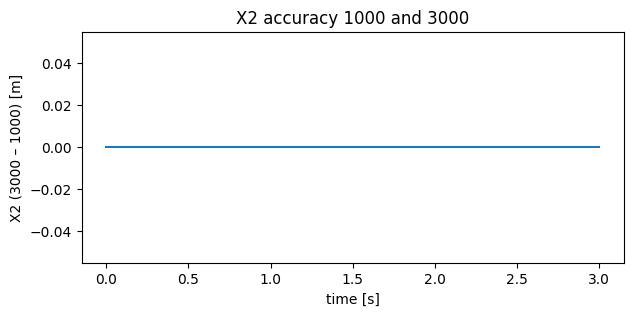

In [ ]:
df_1000 = pd.read_csv("pendulum_data.csv")

path_3000 = "pendulum_data_3000.csv"
if not os.path.exists(path_3000):
    path_3000 = "pendulum_data3000.csv"
df_3000 = pd.read_csv(path_3000)

t_1k  = df_1000["t"].values
x2_1k = df_1000["X2"].values

x2_3k_interp = np.interp(t_1k, df_3000["t"].values, df_3000["X2"].values)

diff = x2_3k_interp - x2_1k
mae  = np.mean(np.abs(diff))
rmse = np.sqrt(np.mean(diff**2))
maxd = np.max(np.abs(diff))

print(f"MAE  (|X2| ) = {mae: .12e} m")
print(f"RMSE (X2_rms) = {rmse:.12e} m")
print(f"MAX  (|X2|max) = {maxd:.12e} m")

plt.figure(figsize=(7,3))
plt.plot(t_1k, diff)
plt.xlabel("time [s]"); plt.ylabel("X2 (3000 – 1000) [m]")
plt.title("X2 accuracy 1000 and 3000")
print(diff)
print(x2_1k)